# Project 4 - Group 2: Algorithm Implementation and Evaluation
## A1: Learning fair representations (LFR) 
## A3: Maximizing fairness under accuracy constraints (gamma and Fine-gamma)



In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as optim
import math
import time
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import utils as ut
from tabulate import tabulate
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from scipy import optimize
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt

## Data pre-processing

For this project, we are using the [COMPAS dataset](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) for our algorithms.

In [3]:
# Load Dataset
data = pd.read_csv('../data/compas-scores-two-years.csv')

In [4]:
variables = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
           'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid','c_jail_in', 'c_jail_out']
data = data[variables]
# data

In [5]:
data = data[(data.race == 'Caucasian') | (data.race == 'African-American')]
data = data[(data.days_b_screening_arrest < 30) & (data.days_b_screening_arrest >= -30)]
data.drop(columns=['days_b_screening_arrest'], inplace = True)
data = data[data.is_recid != -1]
data = data[data.c_charge_degree != 'O']
data['length_of_stay'] = (pd.to_datetime(data["c_jail_out"]) - pd.to_datetime(data['c_jail_in'])).astype('timedelta64[D]')
data.drop(columns=['c_jail_in', 'c_jail_out'], inplace=True)
# data

In [6]:
data['race']= data['race'].replace(['African-American','Caucasian'],[0,1.0])
data['sex'] = data['sex'].replace(['Male','Female'],[0,1.0])
data['age_cat'] = data['age_cat'].replace(['25 - 45','Less than 25', 'Greater than 45'],[0,1.0,2.0])
data['c_charge_degree'] = data['c_charge_degree'].replace(['M','F'],[0,1.0])
data['score_text'] = data['score_text'].replace(['Low', 'High', 'Medium'],[0,1.0,2.0])
data_clean = data[['race', 'age_cat', 'c_charge_degree', 'sex', 'priors_count', 'length_of_stay', 'score_text','two_year_recid', 'decile_score']]
data_clean = data_clean.dropna()
data_clean

,race,age_cat,c_charge_degree,sex,priors_count,length_of_stay,score_text,two_year_recid,decile_score
1,0.0,0.0,1.0,0.0,0,10.0,0.0,1,3
2,0.0,1.0,1.0,0.0,4,1.0,0.0,1,4
6,1.0,0.0,1.0,0.0,14,6.0,2.0,1,6
8,1.0,0.0,0.0,1.0,0,2.0,0.0,0,1
10,1.0,0.0,1.0,0.0,0,1.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...
7207,0.0,0.0,0.0,0.0,0,0.0,0.0,1,2
7208,0.0,1.0,1.0,0.0,0,0.0,1.0,0,9
7209,0.0,1.0,1.0,0.0,0,1.0,2.0,0,7
7210,0.0,1.0,1.0,0.0,0,1.0,0.0,0,3


In [7]:
y = data_clean.two_year_recid
X = data_clean.drop(columns=['two_year_recid'])

In [8]:
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/7,random_state=123)
x_sensitive_tr = X_train.loc[:, 'race']
x_sensitive_te = X_test.loc[:, 'race']
# X_train = X_train.loc[:, X_train.columns != 'race']
# X_test = X_test.loc[:, X_test.columns != 'race']

### Baseline Model

In [9]:
model_base = LogisticRegression().fit(X_train,y_train.flatten())
base_y_train = model_base.predict(X_train)
base_y_test = model_base.predict(X_test)

theta_star = model_base.coef_.flatten()

#metrics
print('Train accuracy: ' + str(model_base.score(X_train,y_train.flatten())))
print('Test accuracy: ' + str(model_base.score(X_test,y_test.flatten())))

Train accuracy: 0.6744803184431667
Test accuracy: 0.6671087533156499


In [10]:
#Calculate the P% 
def p_rule_percent(sensitive, y_predicted):
    
    z_one_index = np.where(sensitive == 1)[0]  
    z_zero_index = np.where(sensitive == 0)[0] 
    
    total_protected = len(z_one_index)
    total_unprotected = len(z_zero_index)

    prediction_protected = np.where(y_predicted[z_one_index]==1)[0]
    prediction_unprotected = np.where(y_predicted[z_zero_index]==1)[0]
    
    total_protected_pred = len(prediction_protected)
    total_unprotected_pred = len(prediction_unprotected)


    protected_ratio = total_protected_pred/total_protected
    unprotected_ratio = total_unprotected_pred/total_unprotected
    
    p_percent_ratio = min(protected_ratio/unprotected_ratio, unprotected_ratio/protected_ratio)
    return p_percent_ratio,protected_ratio, unprotected_ratio 

In [11]:
def calibration(y_pred,y_true,sensitive):
    true0 = 0
    true1 = 0
    total0 = 0
    total1 = 0
    for i in range(len(y_pred)):
        if sensitive[i]==0:
            total0 +=1
            if list(y_true)[i]==y_pred[i]:
                true0 +=1
        else:
            total1 += 1
            if list(y_true)[i]==y_pred[i]:
                true1 += 1
    true0 /= total0
    true1 /= total1
    return abs(true0 - true1)

In [12]:
def parity(y_pred,sensitive):
    true0 = 0
    true1 = 0
    total0 = 0
    total1 = 0
    for i in range(len(y_pred)):
        if sensitive[i]==0:
            total0 +=1
            if (y_pred[i]==1):
                true0 +=1
        else:
            total1 += 1
            if (y_pred[i]==1):
                true1 += 1
    true0 /= total0
    true1 /= total1
    return abs(true0-true1)

In [13]:
def EOD(y_pred,y_true,sensitive):
    true0 = 0
    true1 = 0
    total0 = 0
    total1 = 0
    for i in range(len(y_pred)):
        if(sensitive[i]==0 and y_true [i]==0):
            total0 +=1
            if (y_pred[i]==0):
                true0 +=1
        elif(sensitive[i]==1 and y_true[i]==0):
            total1 += 1
            if (y_pred[i]==0):
                true1 += 1
    true0 /= total0
    true1 /= total1
    return abs(true0-true1)

In [14]:
s = [0,0,0,0,0,1,1,1,1,1]
a = [0,0,1,1,1,0,0,1,1,1]
b = [0,0,1,1,1,0,0,0,1,1]
print(EOD(a,b,s))

0.33333333333333337


In [15]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_sensitive_te = np.array(x_sensitive_te)
base_y_train_2 = np.array(base_y_train)
x_sensitive_tr = np.array(x_sensitive_tr)

#print(p_rule_percent(x_sensitive_tr, y_train))
print("P% for the data without optimization: ",p_rule_percent(x_sensitive_tr, base_y_train_2))
actual_train_loss = log_loss(y_train, model_base.predict_proba(X_train))
print("Actual Train Loss: ", actual_train_loss)
print('test accuracy: ' + str(model_base.score(X_test,y_test.flatten())))
print("calibration for the data without optimization: ",calibration(base_y_test, y_test,x_sensitive_te))
print("parity for the data without optimization: ",parity(base_y_test,x_sensitive_te))
print("Equality of odds(True negative) for the data without optimization: ",EOD(base_y_test,y_test,x_sensitive_te))

P% for the data without optimization:  (0.470369589852681, 0.24189944134078212, 0.5142752562225475)
Actual Train Loss:  0.6053670398617021
test accuracy: 0.6671087533156499
calibration for the data without optimization:  0.05568958147689318
parity for the data without optimization:  0.23152434562749488
Equality of odds(True negative) for the data without optimization:  0.19551407077180272


## Algorithm 1: Learning Fair Representaions

that the proportion of members in a protected group receiving positive classification is identical to the proportion in the population as a whole. Individual fairness ensures that similar individuals should be treated similarly. The authors formulate fairness as an optimization problem with the goal of finding a good representation of the data that encodes the data as well as possible while obfuscating any information about membership in the protected group. They develop a learning approach called Learned Fair Representations (LFR) that learns a set of intermediate representations or prototypes, which are used to satisfy two competing goals: (i) encode the data as well as possible, and (ii) sanitize the encoded representation to be blind to whether or not the individual is from the protected group. The LFR model has two sets of parameters: the prototype locations and the parameters governing the mapping from prototypes to classification decisions. The learning system minimizes an objective function (shown below) with three terms corresponding to the goals of statistical parity, information preservation, and accurate classification.

#### Objective Function:
$L = A_{z} \cdot L_{z} + A_{x} \cdot L_{x} + A_{y} \cdot L_{y}$

(Eqn. 4)

In [16]:
# Data Splitting
data_train, data_test = train_test_split(data_clean, test_size = 1/7, random_state = 1)
data_train, data_val = train_test_split(data_train, test_size = 1/6, random_state = 1)

In [17]:
data_train = pd.concat([data_train.sex,data_train.race,data_train.decile_score,data_train.two_year_recid],axis=1)
data_train = data_train.iloc[:20]
data_val = pd.concat([data_val.sex,data_val.race,data_val.decile_score,data_val.two_year_recid],axis=1)
data_test = pd.concat([data_test.sex,data_test.race,data_test.decile_score,data_test.two_year_recid],axis=1)

### Functions needed to minimize the objective function

#### Equation 12
$d(\textbf{x}_n,\textbf{v}_{k},\alpha) = \sum\limits_{i=1}^{D}\alpha_{i}(x_{ni} - v_{ki})^2$

- This equation calculates the weighted Euclidean distance between data points and cluster centroids.

In [18]:
# Returns a distance matrix with shape (num_data_points, num_centroids)
def weighted_euclidean_distance(data_points, centroids, feature_weights):
    # data_points: a dataset of shape (num_data_points, num_features)
    # centroids: a list of centroid vectors, each of length num_features
    # feature_weights: a list of weights for each feature

    num_data_points = data_points.shape[0]
    num_features = data_points.shape[1]
    num_centroids = len(centroids)

    # Initialize the distance matrix
    distance_matrix = np.zeros((num_data_points, num_centroids))

    # Calculate weighted Euclidean distances
    for point_idx in range(num_data_points):
        for centroid_idx in range(num_centroids):
            for feature_idx in range(num_features):
                distance_matrix[point_idx, centroid_idx] += (
                    feature_weights[feature_idx] *
                    (data_points.iloc[point_idx][feature_idx] - centroids[centroid_idx, feature_idx])**2)

    return distance_matrix

#### Equation 3

$M_{n,k} = P(Z = k|\textbf{x}_{n})= \dfrac{e^{−d(\textbf{x}, \textbf{v}_{k}))}}{\sum\limits_{j=1}^{K} e^{−d(\textbf{x}, \textbf{v}_{j})}}, ∀n,k$

- This equation calculates the probability matrix P(cluster=k|data_point), representing the probability that each data point belongs to a specific cluster centroid.

In [19]:
# Returns a probability matrix with shape (num_data_points, num_centroids)
def calculate_probability_matrix(distance_matrix, num_centroids):
    # distance_matrix: a distance matrix with shape (num_data_points, num_centroids)
    # num_centroids: the number of centroids

    num_data_points = distance_matrix.shape[0]

    probability_matrix = np.zeros((num_data_points, num_centroids))
    exp_distances = np.zeros((num_data_points, num_centroids))

    # Calculate the probability matrix
    for data_point_idx in range(num_data_points):
        denominator = 0
        for centroid_idx in range(num_centroids):
            exp_distances[data_point_idx, centroid_idx] = math.exp(-1 * distance_matrix[data_point_idx, centroid_idx])
            denominator += exp_distances[data_point_idx, centroid_idx]
        for centroid_idx in range(num_centroids):
            probability_matrix[data_point_idx, centroid_idx] = exp_distances[data_point_idx, centroid_idx] / denominator

    return probability_matrix

#### Equation 6
$M_{k}^{+} = \mathbb{E}_{\textbf{x}∈X^{+}}P(Z = k|\textbf{x}) = \dfrac{1}{|X_{0}^{+}|}\sum\limits_{n∈X_{0}^{+}}M_{n,k}$

$M_{k}^{-}$ similarly

- This equation calculates the list of cluster probabilities M_k.

In [20]:
# Returns a list of probabilities for each cluster centroid
def calculate_cluster_probabilities(data_points, probability_matrix, num_centroids):
    # data_points: the dataset
    # probability_matrix: the probability matrix P(cluster=k|data_point)
    # num_centroids: the number of centroids

    num_data_points = data_points.shape[0]

    cluster_probabilities = np.zeros(num_centroids)

    # Calculate cluster probabilities
    for centroid_idx in range(num_centroids):
        for data_point_idx in range(num_data_points):
            cluster_probabilities[centroid_idx] += probability_matrix[data_point_idx, centroid_idx]
        cluster_probabilities[centroid_idx] /= num_data_points

    return cluster_probabilities

#### Equation 8, 9

$L_{x} = \sum\limits_{n=1}^{N}(x_{n} - \hat{x}_{n})^2$

$\hat{x}_{n} = \sum\limits_{k=1}^{K}M_{n,k}\textbf{v}_{k}$

- This equation calculate the reconstructed data points and the reconstruction error L_x.

In [21]:
# Returns the reconstructed data points with shape (num_data_points, num_features) and L_x
def reconstruct_data_points(data_points, probability_matrix, centroids):
    # data_points: the dataset
    # probability_matrix: the probability matrix P(cluster=k|data_point)
    # centroids: a list of centroid vectors, each of length num_features

    num_data_points = probability_matrix.shape[0]
    num_features = data_points.shape[1]
    num_centroids = probability_matrix.shape[1]

    reconstructed_data_points = np.zeros((num_data_points, num_features))
    reconstruction_error = 0

    # Calculate reconstructed data points
    for data_point_idx in range(num_data_points):
        for feature_idx in range(num_features):
            for centroid_idx in range(num_centroids):
                reconstructed_data_points[data_point_idx, feature_idx] += (
                    probability_matrix[data_point_idx, centroid_idx] * centroids[centroid_idx, feature_idx]
                )
        # Calculate reconstruction error
        reconstruction_error += (data_points.iloc[data_point_idx][feature_idx] - reconstructed_data_points[data_point_idx, feature_idx])**2

    return reconstructed_data_points, reconstruction_error

#### Equation 10, 11

$L_{y} = \sum\limits_{n=1}^{N}-y_{n}log\hat{y}_{n}-(1-y_{n})log(1-\hat{y}_{n})$

$\hat{y}_{n} = \sum\limits_{k=1}^{K}M_{n,k}w_{k}$

- This equaiton calculates the list of predicted labels for data points and the label prediction error L_y.


In [22]:
# Returns the list of predicted labels and L_y
def predict_labels(probability_matrix, weights, labels):
    # probability_matrix: the probability matrix P(cluster=k|data_point)
    # weights: a list of weights of length num_centroids
    # labels: the corresponding list of labels for the data points

    num_data_points = probability_matrix.shape[0]
    num_centroids = probability_matrix.shape[1]

    predicted_labels = np.zeros(num_data_points)
    prediction_error = 0

    # Calculate predicted labels
    for data_point_idx in range(num_data_points):
        for centroid_idx in range(num_centroids):
            predicted_labels[data_point_idx] += probability_matrix[data_point_idx, centroid_idx] * weights[centroid_idx]
        
        # Calculate prediction error
        prediction_error += (
            -1 * labels.iloc[data_point_idx] * np.log(predicted_labels[data_point_idx]) -
            (1 - labels.iloc[data_point_idx]) * np.log(1 - predicted_labels[data_point_idx])
        )

    return predicted_labels, prediction_error

#### Equation 7

$L_{z} = \sum\limits_{k=1}^{K}|M_{k}^{+} - M_{k}^{-}|$

In [23]:
def L(params, sensitive_data, nonsensitive_data, sensitive_labels, nonsensitive_labels, num_centroids, weight_Lz, weight_Lx, weight_Ly):
    # params: the list of parameters
    # sensitive_data: the sensitive dataset
    # nonsensitive_data: the nonsensitive dataset
    # sensitive_labels: the list of labels for the sensitive dataset
    # nonsensitive_labels: the list of labels for the nonsensitive dataset
    # num_centroids, weight_Lz, weight_Lx, and weight_Ly are hyperparameters, decided by the users

    sensitive_num_data_points, sensitive_num_features = sensitive_data.shape
    nonsensitive_num_data_points, nonsensitive_num_features = nonsensitive_data.shape

    # Form parameters in correct format
    alpha_sensitive = params[:sensitive_num_features]
    alpha_nonsensitive = params[sensitive_num_features : 2 * sensitive_num_features]
    weights = params[2 * sensitive_num_features : (2 * sensitive_num_features) + num_centroids]
    centroids = np.matrix(params[(2 * sensitive_num_features) + num_centroids:]).reshape((num_centroids, sensitive_num_features))

    # Calculate the distance matrix
    dist_sensitive = weighted_euclidean_distance(sensitive_data, centroids, alpha_sensitive)
    dist_nonsensitive = weighted_euclidean_distance(nonsensitive_data, centroids, alpha_nonsensitive)

    # Calculate the probability matrix M_nk
    prob_matrix_sensitive = calculate_probability_matrix(dist_sensitive, num_centroids)
    prob_matrix_nonsensitive = calculate_probability_matrix(dist_nonsensitive, num_centroids)

    # Calculate the cluster probability matrix M_k
    cluster_prob_sensitive = calculate_cluster_probabilities(sensitive_data, prob_matrix_sensitive, num_centroids)
    cluster_prob_nonsensitive = calculate_cluster_probabilities(nonsensitive_data, prob_matrix_nonsensitive, num_centroids)

    # Calculate L_z
    L_z = 0
    for centroid_idx in range(num_centroids):
        L_z += abs(cluster_prob_sensitive[centroid_idx] - cluster_prob_nonsensitive[centroid_idx])

    # Calculate reconstructed data points and L_x
    reconstructed_sensitive, L_x_sensitive = reconstruct_data_points(sensitive_data, prob_matrix_sensitive, centroids)
    reconstructed_nonsensitive, L_x_nonsensitive = reconstruct_data_points(nonsensitive_data, prob_matrix_nonsensitive, centroids)
    L_x = L_x_sensitive + L_x_nonsensitive

    # Calculate predicted labels and L_y
    predicted_sensitive, L_y_sensitive = predict_labels(prob_matrix_sensitive, weights, sensitive_labels)
    predicted_nonsensitive, L_y_nonsensitive = predict_labels(prob_matrix_nonsensitive, weights, nonsensitive_labels)
    L_y = L_y_sensitive + L_y_nonsensitive

    # The function we want to minimize
    loss_metric = weight_Lz * L_z + weight_Lx * L_x + weight_Ly * L_y

    return loss_metric

In [24]:
# Apply a threshold to the predicted labels to convert them into binary values (0 or 1)
def apply_prediction_threshold(predictions):
    for idx in range(len(predictions)):
        if predictions[idx] >= 0.5:
            predictions[idx] = 1
        else:
            predictions[idx] = 0
    return predictions

In [25]:
# Calculate predicted labels using the best parameters
def calculate_predictions(params, num_features, num_centroids, sensitive_data, nonsensitive_data, sensitive_labels, nonsensitive_labels):
    # Reformat parameters
    best_alpha_sensitive = params[:num_features]
    best_alpha_nonsensitive = params[num_features : 2 * num_features]
    best_weights = params[2 * num_features : (2 * num_features) + num_centroids]
    best_centroids = np.matrix(params[(2 * num_features) + num_centroids:]).reshape((num_centroids, num_features))

    # Calculate the distance matrix
    best_dist_sensitive = weighted_euclidean_distance(sensitive_data, best_centroids, best_alpha_sensitive)
    best_dist_nonsensitive = weighted_euclidean_distance(nonsensitive_data, best_centroids, best_alpha_nonsensitive)

    # Calculate the probability matrix M_nk
    best_prob_matrix_sensitive = calculate_probability_matrix(best_dist_sensitive, num_centroids)
    best_prob_matrix_nonsensitive = calculate_probability_matrix(best_dist_nonsensitive, num_centroids)

    # Calculate the predicted labels
    predicted_sensitive_labels, _ = predict_labels(best_prob_matrix_sensitive, best_weights, sensitive_labels)
    predicted_nonsensitive_labels, _ = predict_labels(best_prob_matrix_nonsensitive, best_weights, nonsensitive_labels)

    return predicted_sensitive_labels, predicted_nonsensitive_labels

In [26]:
# Calculate the total accuracy, separate accuracy for sensitive (African American) and nonsensitive (Caucasian) groups, and calibration
def calculate_calibration(predicted_sensitive_labels, predicted_nonsensitive_labels, true_sensitive_labels, true_nonsensitive_labels):
    # Apply threshold to predictions
    converted_pred_sensitive = apply_prediction_threshold(predicted_sensitive_labels)
    converted_pred_nonsensitive = apply_prediction_threshold(predicted_nonsensitive_labels)

    predicted_sensitive_labels_df = pd.DataFrame(converted_pred_sensitive)
    predicted_nonsensitive_labels_df = pd.DataFrame(converted_pred_nonsensitive)

    # Calculate the accuracy
    accuracy_sensitive = accuracy_score(true_sensitive_labels, predicted_sensitive_labels_df)
    accuracy_nonsensitive = accuracy_score(true_nonsensitive_labels, predicted_nonsensitive_labels_df)

    all_true_labels = true_sensitive_labels.append(true_nonsensitive_labels)
    all_predicted_labels = predicted_sensitive_labels_df.append(predicted_nonsensitive_labels_df)
    total_accuracy = accuracy_score(all_predicted_labels, all_true_labels)

    table = [["Overall",total_accuracy],["Sensitive",accuracy_sensitive],
            ["Nonsensitive",accuracy_nonsensitive],
             ["Calibration",abs(accuracy_sensitive - accuracy_nonsensitive)]]
    
    print(tabulate(table, headers = ["Group","Accuracy"],tablefmt = "orgtbl"))
    

In [27]:
# def calculate_parity(y_predicted, sensitive):
#     true0 = 0
#     true1 = 0
#     total0 = 0
#     total1 = 0
    
#     for i in range(len(y_predicted)):
#         if sensitive[i] == 0:
#             total0 += 1
#             if y_predicted[i] == 1:
#                 true0 += 1
#         else:
#             total1 += 1
#             if y_predicted[i] == 1:
#                 true1 += 1
    
#     true0 /= total0
#     true1 /= total1
#     return abs(true0-true1)

In [28]:
# The main LFR function returns the best parameters and the results for training and validation accuracy
def LFR(training_data, validation_data, y_name, sensitive_variable_name, K, A_z, A_x, A_y):
    # Divide the training set into sensitive & nonsensitive groups
    sensitive_training = training_data[training_data[sensitive_variable_name]==0]
    nonsensitive_training = training_data[training_data[sensitive_variable_name]==1]

    # Divide the validation set into sensitive & nonsensitive groups
    sensitive_validation = validation_data[validation_data[sensitive_variable_name]==0]
    nonsensitive_validation = validation_data[validation_data[sensitive_variable_name]==1]

    # Remove sensitive variable in the sensitive and nonsensitive training and validation groups
    sensitive_training = sensitive_training.drop(columns=[sensitive_variable_name])
    sensitive_validation = sensitive_validation.drop(columns=[sensitive_variable_name])
    nonsensitive_training = nonsensitive_training.drop(columns=[sensitive_variable_name])
    nonsensitive_validation = nonsensitive_validation.drop(columns=[sensitive_variable_name])

    # Assign y labels for sensitive and nonsensitive training groups
    y_sensitive_training = sensitive_training[y_name]
    sensitive_training = sensitive_training.drop(columns=[y_name])
    y_nonsensitive_training = nonsensitive_training[y_name]
    nonsensitive_training = nonsensitive_training.drop(columns=[y_name])

    # Assign y labels for sensitive and nonsensitive validation groups
    y_sensitive_validation = sensitive_validation[y_name]
    sensitive_validation = sensitive_validation.drop(columns=[y_name])
    y_nonsensitive_validation = nonsensitive_validation[y_name]
    nonsensitive_validation = nonsensitive_validation.drop(columns=[y_name])

    # Initialize random values for parameters alpha and w (summing up to 1)
    alpha_sensitive = np.random.random_sample((sensitive_training.shape[1],))
    alpha_sensitive /= alpha_sensitive.sum()
    alpha_nonsensitive = np.random.random_sample((nonsensitive_training.shape[1],))
    alpha_nonsensitive /= alpha_nonsensitive.sum()
    w_random = np.random.random_sample((K,))
    w = w_random / w_random.sum()
    v = np.random.random((K, sensitive_training.shape[1]))

    # Prepare initial parameters
    initial_parameters = np.concatenate([alpha_sensitive, alpha_nonsensitive, w, v.flatten()])

    # Define parameter bounds
    bounds = [(0, 1)] * (sensitive_training.shape[1] + nonsensitive_training.shape[1] + K)
    bounds += [(None, None)] * (K * sensitive_training.shape[1])

    # Minimize the metric using parameters alpha, w, and v
    optimized_params, min_L, _ = optim.fmin_l_bfgs_b(L, x0=initial_parameters, epsilon=1e-5,
                                         args=(sensitive_training, nonsensitive_training, y_sensitive_training,
                                               y_nonsensitive_training, K, A_z, A_x, A_y),
                                         bounds=bounds, approx_grad=True,
                                         maxfun=150000, maxiter=150000)

    # Predict y_n_hat for the training set
    y_hat_sensitive_train, y_hat_nonsensitive_train = calculate_predictions(optimized_params, sensitive_training.shape[1], K, sensitive_training,
                                                nonsensitive_training, y_sensitive_training, y_nonsensitive_training)

    print("Training set:")
    calculate_calibration(y_hat_sensitive_train, y_hat_nonsensitive_train, y_sensitive_training, y_nonsensitive_training)
        
    # Predict y_n_hat for the validation set
    y_hat_sensitive_val, y_hat_nonsensitive_val = calculate_predictions(optimized_params, sensitive_validation.shape[1], K, sensitive_validation,
                                              nonsensitive_validation, y_sensitive_validation, y_nonsensitive_validation)

    print("")
    print("Validation set:")
    calculate_calibration(y_hat_sensitive_val, y_hat_nonsensitive_val, y_sensitive_validation, y_nonsensitive_validation)

    return optimized_params

In [29]:
# call LFR function to train the model
start = time.time()
optimized_params_for_test = LFR(data_train, data_val, 'two_year_recid', 'race', 10, 0.3, 0.3, 0.4)
end = time.time() 
print( f"Total training time: {end-start} seconds")

Training set:
| Group        |   Accuracy |
|--------------+------------|
| Overall      |   0.75     |
| Sensitive    |   0.636364 |
| Nonsensitive |   0.888889 |
| Calibration  |   0.252525 |

Validation set:
| Group        |   Accuracy |
|--------------+------------|
| Overall      |  0.526525  |
| Sensitive    |  0.535637  |
| Nonsensitive |  0.512027  |
| Calibration  |  0.0236097 |
Total training time: 230.12980484962463 seconds


In [30]:
# Testing result
sensitive_test = data_test[data_test['race'] == 0]
nonsensitive_test = data_test[data_test['race'] == 1]

sensitive_test = sensitive_test.drop(columns=['race'])
nonsensitive_test = nonsensitive_test.drop(columns=['race'])

y_sensitive_test = sensitive_test['two_year_recid']
sensitive_test = sensitive_test.drop(columns=['two_year_recid'])

y_nonsensitive_test = nonsensitive_test['two_year_recid']
nonsensitive_test = nonsensitive_test.drop(columns=['two_year_recid'])

start = time.time()
y_hat_sensitive_test, y_hat_nonsensitive_test = calculate_predictions(optimized_params_for_test, sensitive_test.shape[1], 10, sensitive_test,
             nonsensitive_test, y_sensitive_test, y_nonsensitive_test)
end = time.time()
print(f"Testing time: {end - start} seconds")
calculate_calibration(y_hat_sensitive_test, y_hat_nonsensitive_test, y_sensitive_test, y_nonsensitive_test)


Testing time: 1.6217546463012695 seconds
| Group        |   Accuracy |
|--------------+------------|
| Overall      |  0.501326  |
| Sensitive    |  0.509804  |
| Nonsensitive |  0.488136  |
| Calibration  |  0.0216683 |


## A3 - Maximizing fairness under accuracy constraints

The goal of this algorithm is to ensure compliance with the disparate impact by maximizing the fairness subject to accuracy constraints. Minimizing the corresponding absolute decision boundary covariance over the training set with constraints could help us find the decision boundary parameters. 

Here we use one gamma across individuals. This allows a relaxation on the accuracy from the unconstrained case with regard to accuracy so that the algorithm can minimize unfairness. The formular is defined below:

<center>$min|\frac{1}{N}\sum\limits_{i=1}^{N}(z_{i}-\bar z)d_{\theta}(x_{i})|$

<center>$s.t.  L(\theta) <= (1+\gamma)L(\theta ^{*})$</center>



In [31]:
model_base = LogisticRegression().fit(X_train,y_train.flatten())
base_y_train = model_base.predict(X_train)
base_y_test = model_base.predict(X_test)
theta_star = model_base.coef_.flatten()
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_sensitive_te = np.array(x_sensitive_te)
base_y_train_2 = np.array(base_y_train)
x_sensitive_tr = np.array(x_sensitive_tr)
actual_train_loss = log_loss(y_train, model_base.predict_proba(X_train))

In [32]:
def optimize_function(w, x, protected_var):
    dist_bound = np.dot(w, X_train.T)
    protected_cov = (protected_var - np.mean(protected_var)) * dist_bound
    return float(abs(sum(protected_cov))) / float(X_train.shape[0])

def log_loss_constraint(weights, x, y, gamma):
    prod = np.dot(x, weights.reshape(X_train.shape[1],1))
    pred_probability = 1/(1+np.exp(-prod))
    predicted_classes = np.concatenate((1-pred_probability, pred_probability), axis = 1)
    loss = log_loss(y, predicted_classes)
    return (1+gamma)*actual_train_loss - loss 

In [33]:
def accuracy(w, x, y):
    shape = x.shape[1]
    pred = np.dot(x, w.reshape(x.shape[1],1))
    pred_prob = 1/(1+ np.exp(-pred))
    pred_prob[pred_prob>=0.5] = 1
    pred_prob[pred_prob<0.5] = 0
    value = np.where(pred_prob== y.reshape(pred_prob.shape))
    accuracy = value[0].shape[0]/pred_prob.shape[0]
    return accuracy, pred_prob

In [34]:
def optimization(x_train, y_train, x_test, y_test, protected_attr, protected_attr_test, gamma, optimal_weights):
    cons = {'type':'ineq', 'fun': log_loss_constraint, 'args': (x_train, y_train, gamma)}

    result = optimize.minimize(optimize_function, x0=optimal_weights,args= (x_train,protected_attr),method='SLSQP',constraints=cons,options={'maxiter':10000})
    
    accuracy_train, pred_y = accuracy(result.x, x_train, y_train)
    p_rule_val, prot_perc, nonp_perc = p_rule_percent(protected_attr, pred_y)
    calib_train = calibration(pred_y, y_train.flatten(),x_sensitive_tr)
    
    accuracy_test, y_pred_test = accuracy(result.x, x_test, y_test)
    p_rule_val_test, prot_perc_test, nonp_perc_test = p_rule_percent(protected_attr_test, y_pred_test)
    calib_test = calibration(y_pred_test, y_test.flatten(),x_sensitive_te)
    parity_test = parity(y_pred_test,x_sensitive_te)
    EOD_test = EOD(y_pred_test, y_test.flatten(),x_sensitive_te)
    
    print("\nTest Accuracy for gamma ",gamma,": ",accuracy_test)
    print("P Rule percent: ", p_rule_val_test)
    print("calibration: ", calib_test)
    print("parity: ", parity_test)
    print("Equality of odds: ", EOD_test)
    
    return accuracy_train,pred_y, p_rule_val, calib_train, accuracy_test, p_rule_val_test, y_pred_test,calib_test, parity_test, EOD_test

In [35]:
bias_factor_train = np.ones(X_train.shape[0]).reshape(X_train.shape[0],1)
bias_factor_test = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)

X_test =  np.concatenate((X_test, bias_factor_test), axis = 1)
X_train = np.concatenate((X_train, bias_factor_train), axis = 1)
#Creating the Weights Dataframe
weights_df = np.concatenate((model_base.coef_, model_base.intercept_.reshape(1,1)),axis=1)
gamma_list = [0.1,0.15,0.2,0.5]
accuracy_list, p_list, cal_list_tr, cal_list_te =  [],[],[],[]
parity_list_te, EOD_te = [],[]
y_pred_train_list = []
y_pred_test_list = []
accuracy_list_test, p_test = [],[]
for g in gamma_list:    
    (accuracy_train, pred_y, p_rule_val, calib_train, accuracy_test, p_rule_val_test, y_pred_test, calib_test, parity_test, EOD_test) = optimization(X_train, y_train, X_test, y_test,x_sensitive_tr,x_sensitive_te,g,
                                                                                    weights_df)
                                                                                     
    accuracy_list.append(accuracy_train)
    y_pred_train_list.append(pred_y)
    p_list.append(p_rule_val)
    accuracy_list_test.append(accuracy_test)
    y_pred_test_list.append(y_pred_test)
    p_test.append(p_rule_val_test)
    cal_list_tr.append(calib_train)
    cal_list_te.append(calib_test)
    parity_list_te.append(parity_test)
    EOD_te.append(EOD_test)


Test Accuracy for gamma  0.1 :  0.6087533156498673
P Rule percent:  0.8344241446694998
calibration:  0.08445081973151347
parity:  0.03867191178920981
Equality of odds:  0.00529395374756203

Test Accuracy for gamma  0.15 :  0.5477453580901857
P Rule percent:  0.7044728434504792
calibration:  0.13959705287865942
parity:  0.02680518426753023
Equality of odds:  0.02477013095569791

Test Accuracy for gamma  0.2 :  0.5225464190981433
P Rule percent:  0.7886117409926934
calibration:  0.1553686437301225
parity:  0.006078256648772394
Equality of odds:  0.00025076623014763655

Test Accuracy for gamma  0.5 :  0.5106100795755968
P Rule percent:  0.7827476038338659
calibration:  0.1539269594951932
parity:  0.004433722370737431
Equality of odds:  0.01005851212036779


The accuracy of the model decrecases from around 0.67 (baseline model) to around 0.55. The calibration has increased from around 0.056 (baseline model) to around 0.15. The P rule percent has increased from around 0.47 (baseline model) to around 0.8. The parity has decreased from 0.23 (baseline model) to around 0.02. The Equality of odds has decreased from around 0.196 (baseline model) to around 0.01.

Improving the p-rule percent can lead to better fairness compared to baseline model. The calibration, parity, equality of odds are metrics used to evaluate the fairness of a binary classifier with respect to two groups. Ideally, we want them to be as close to 0 as possible, indicating that there is no significant difference in the proportion of positive outcomes between the two groups.

A gamma value of 0.1 is relatively good since it leads to increased p-rule value and parity and equality of odds values which are closed to 0, while the accuracy is not decreased much.

## Graphs

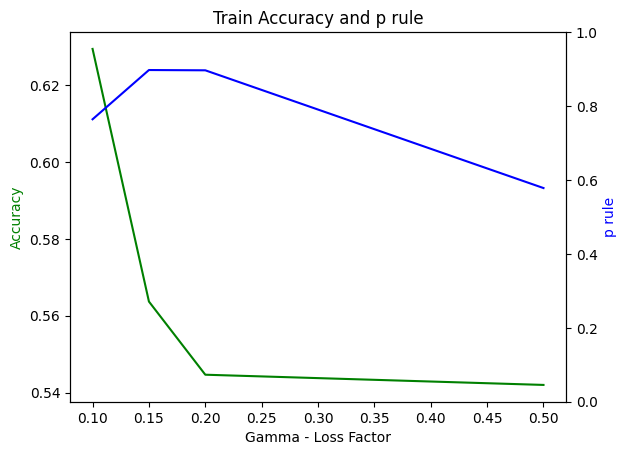

In [36]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list , 'g-')
ax2.plot(gamma_list, p_list, 'b-')
ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('p rule', color='b')
ax2.set_title('Train Accuracy and p rule')
ax2.set_ylim(0,1)
plt.show()

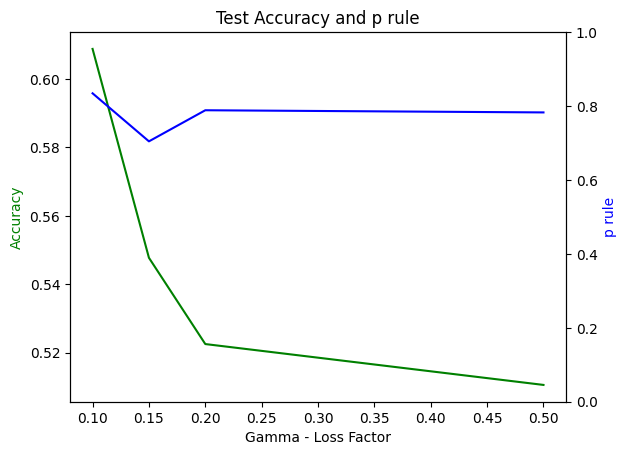

In [38]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gamma_list, accuracy_list_test , 'g-')
ax2.plot(gamma_list, p_test, 'b-')
ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('p rule', color='b')
ax2.set_title('Test Accuracy and p rule')
ax2.set_ylim(0, 1)
plt.show()

Text(0.5, 1.0, 'Test calibration')

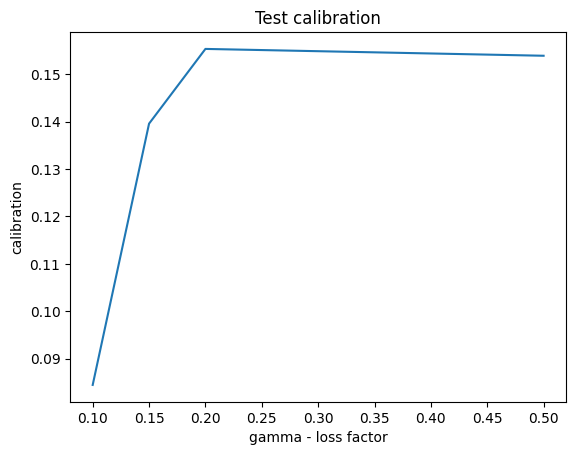

In [39]:
plt.plot(gamma_list, cal_list_te)
plt.xlabel('gamma - loss factor')
plt.ylabel('calibration')
plt.title('Test calibration')

Text(0.5, 1.0, 'Test parity')

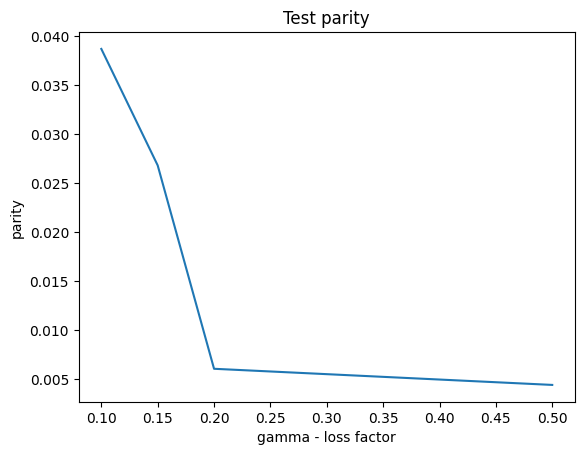

In [40]:
plt.plot(gamma_list, parity_list_te)
plt.xlabel('gamma - loss factor')
plt.ylabel('parity')
plt.title('Test parity')

Text(0.5, 1.0, 'Test EOD')

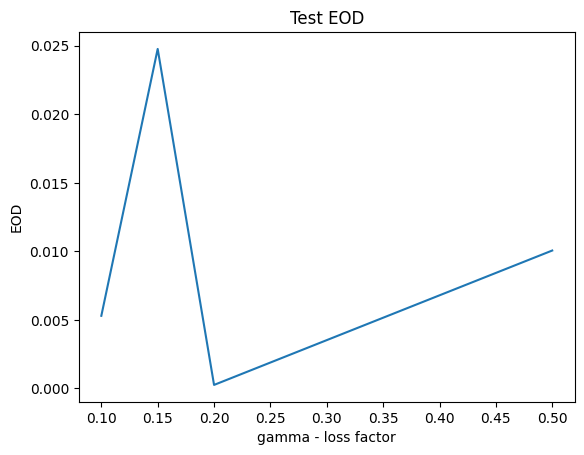

In [41]:
plt.plot(gamma_list, EOD_te)
plt.xlabel('gamma - loss factor')
plt.ylabel('EOD')
plt.title('Test EOD')